In [1]:
"""
Case study to demonstrate the role of 
Parallel Tempering (Simulated Annealing)
in Monte Carlo Simulations.

"""
import math
import numpy as np
import random as rnd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def potential(x):

    a = 1 + math.sin(2*math.pi*x);

    if x < -2:
        U = math.inf
    elif (-2<=x and x<=-1.25):
        U = 1*a
    elif (-1.25<=x and x<=-0.25):
        U = 2*a
    elif (-0.25<=x and x<=0.75):
        U = 3*a
    elif (0.75<=x and x<=1.75):
        U = 4*a
    elif (1.75<=x and x<=2):
        U = 5*a
    else:
        U = math.inf
        
    return U

        
def analytical_solution():

    x = np.linspace(-2,2,1000)
    Z = 0.2244
    beta = 1/0.05
    P = np.zeros(len(x))

    for i in range(0,len(x)):
        a = 1+math.sin(2*math.pi*x[i])
    
        if(-2<=x[i] and x[i]<=-1.25):
            P[i] = math.exp(-beta*a)/Z
 
        elif(-1.25<=x[i] and x[i]<=-0.25):
            P[i] = math.exp(-beta*2*a)/Z
     
        elif(-0.25<=x[i] and x[i]<=0.75):
            P[i] = math.exp(-beta*3*a)/Z
    
        elif(0.75<=x[i] and x[i]<=1.75):
            P[i] = math.exp(-beta*4*a)/Z
            
        else:
            P[i] = math.exp(-beta*5*a)/Z 
    
    return x,P


def Metropolis(xi,ui,xnew,unew,T):
    
    deltaU = unew - ui
    if (deltaU < 0):
        xi = xnew
        ui = unew
    elif (np.random.uniform(0,1,1) < math.exp(-deltaU/T)):
        xi = xnew
        ui = unew
        
    return xi,ui

def PT_swap(x,u,temp):

    r = rnd.randint(1, len(temp)-1)
    delBeta = 1/(temp[r] - 1/temp[r-1])
    delU = u[r]-u[r-1]

    # Parallel Tempering Swap Move
    if (delU*delBeta > 0):
        x[r], x[r-1] = x[r-1], x[r]
        u[r], u[r-1] = u[r-1], u[r]
                
    elif (rnd.uniform(0,1) < math.exp(delU*delBeta)):
        x[r], x[r-1] = x[r-1], x[r]
        u[r], u[r-1] = u[r-1], u[r]
        
    return x,u

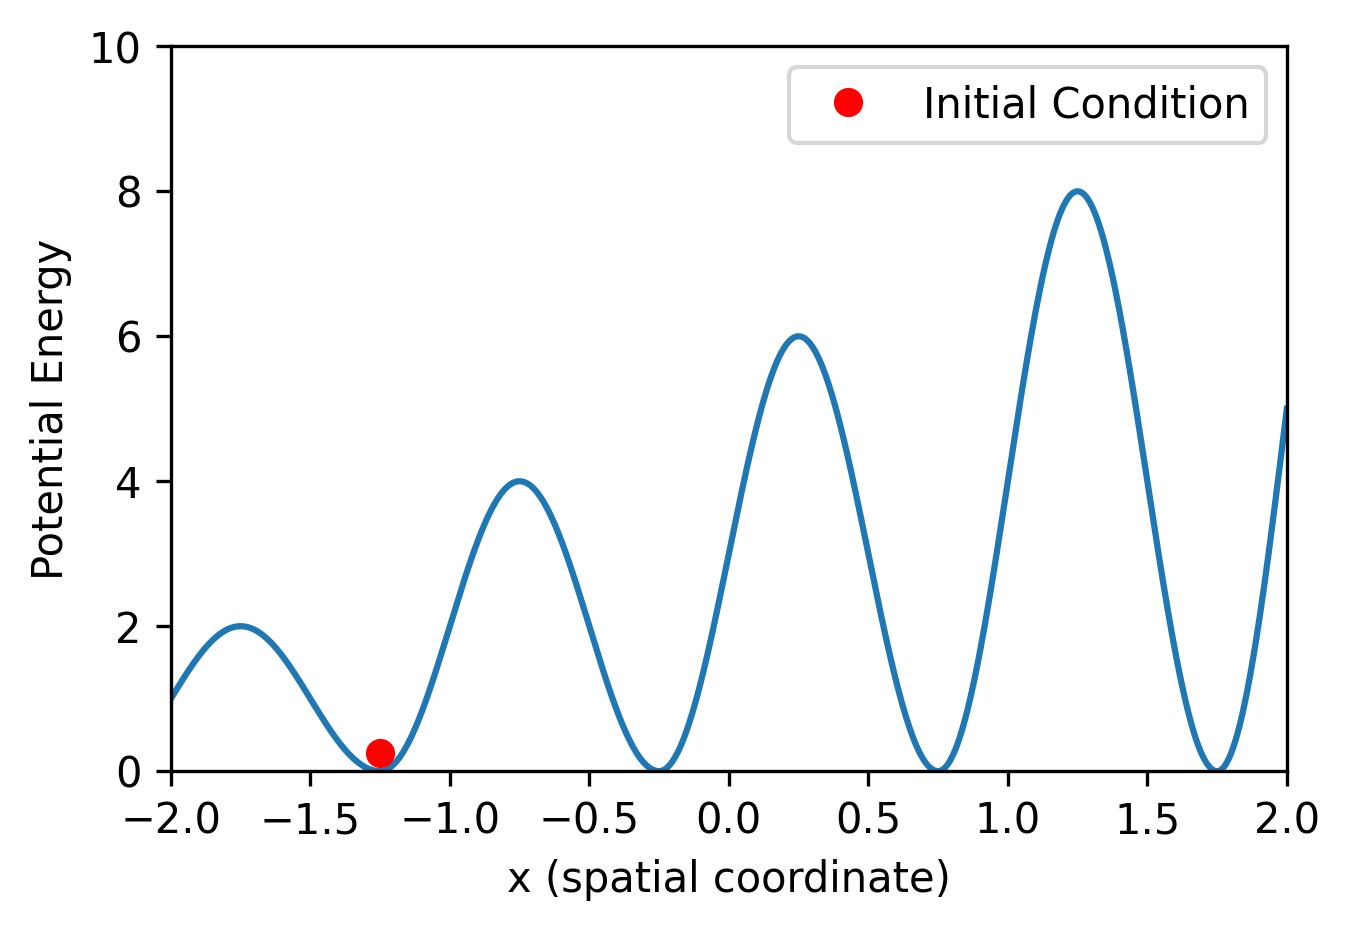

In [3]:
x = np.linspace(-2,2,1000)
U = [potential(xi) for xi in x]
[fig, ax] = plt.subplots(figsize=(4.8,3.2), dpi=300)
ax.plot(x,U)
ax.plot(-1.25,0.25,'or', label='Initial Condition')
ax.set_xlim(-2,2)
ax.set_ylim(0,10)
ax.set_ylabel('Potential Energy')
ax.set_xlabel('x (spatial coordinate)')
ax.legend()

The goal of MC simulation here is to let particle to explore above free energy surface following the Bolztmann distribution. This energy surface has four minima ($U=0$), located at -1.25, -0.25, 0.75, and 1.75, respectively. According to Boltzmann distribution, the particle should have equal proabibilty of being in any of these wells ($U=0 \implies p = 1$ for all wells).

In [4]:
# System parameters
rep = 3
steps = int(1E7)
x = np.zeros(rep)
u = np.zeros(rep)
pos = np.zeros((steps,rep))

temp =[0.05, 0.3, 2] 
delx =[0.2, 0.2, 0.2]

(-2.0, 2.0)

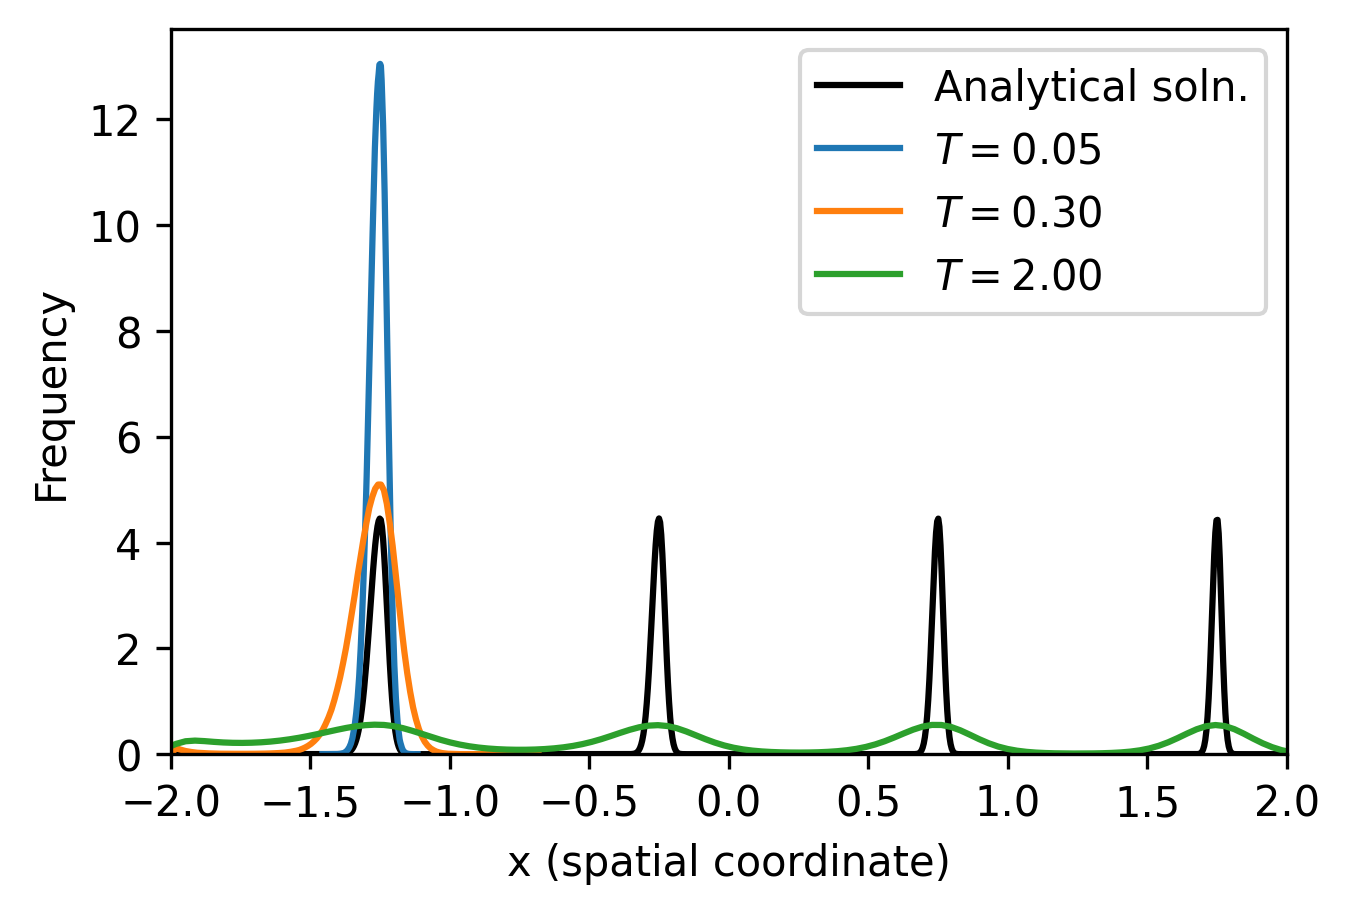

In [5]:
# Simple Metropolis MC

# Initial condition
x = -1.25+0.01*(np.random.uniform(0,1,3)-0.5)
u = [potential(xi) for xi in x]

for i in range(steps):      
    for j in range (len(temp)):

        xnew = x[j] + delx[j]*(rnd.uniform(0,1)-0.5)
        unew = potential(xnew)
        x[j],u[j] = Metropolis(x[j],u[j],xnew,unew,temp[j])
        
    pos[i,:] = x[:]
   

# Plots
[fig, ax] = plt.subplots(figsize=(4.8,3.2), dpi=300)
[x, P] = analytical_solution()
ax.plot(x, P, 'k', label='Analytical soln.')

[sns.distplot(pos[:,i], bins = 500, hist=False, 
              ax=ax, label='$T=%0.2f$'%(temp[i])) for i in range(0, rep)]
ax.set_ylabel('Frequency')
ax.set_xlabel('x (spatial coordinate)')
ax.set_xlim(-2,2)

As seen in the above figure, the naive MMC simulation could not let the particle at lower temperature to jump over local (first minima from where it started), while the particle at higher temperature explored the surface throughly leading to equal probability of being in any of the four wells. 

(-2.0, 2.0)

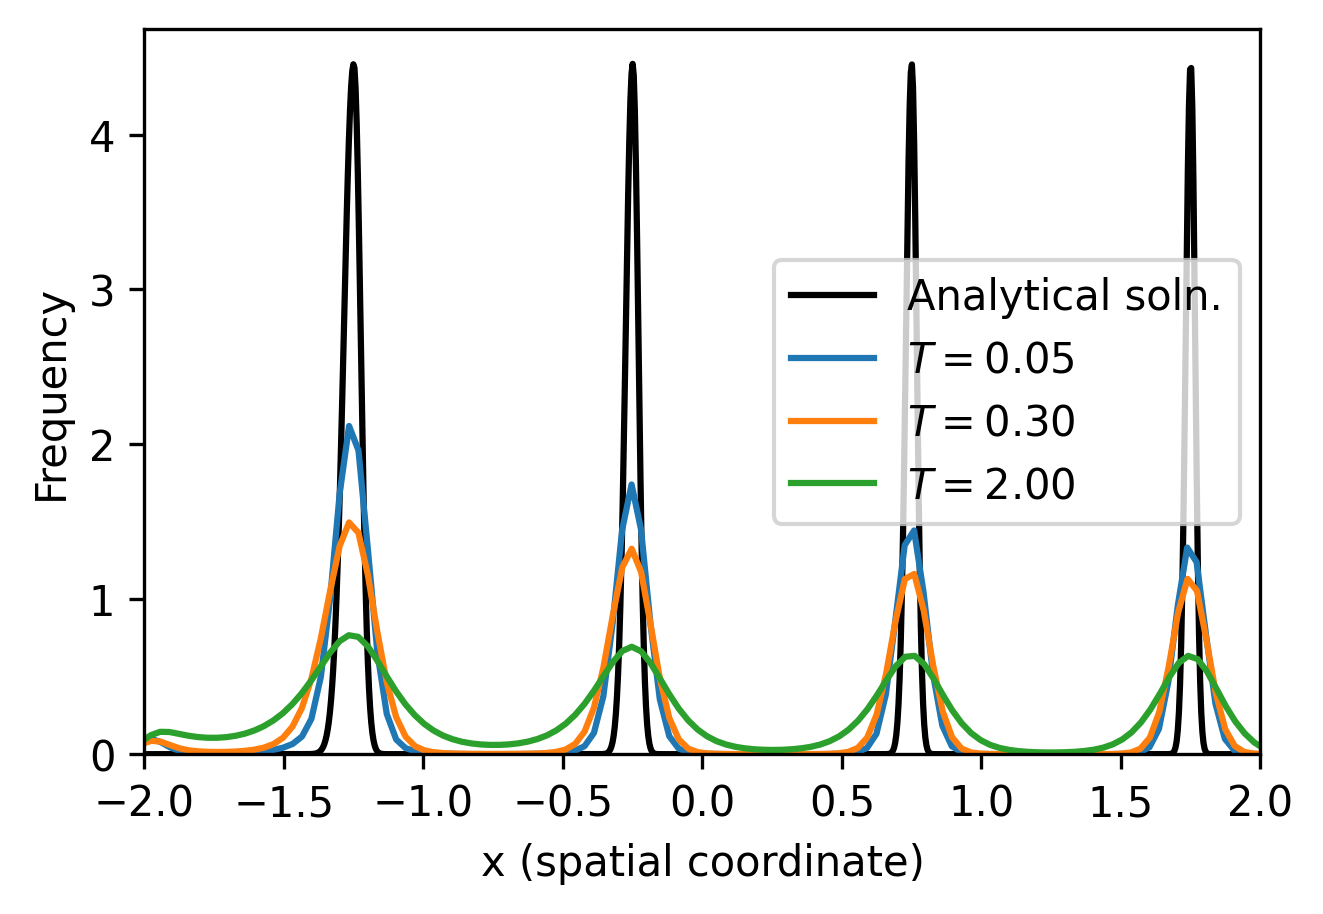

In [6]:
# Metropolis MC with Parallel Tempering
T_swap_step = 10

# Intial condition
x = -1.25+0.01*(np.random.uniform(0,1,3)-0.5)
u = [potential(xi) for xi in x]

for i in range(steps):      
    for j in range (len(temp)):
     
        if(i%T_swap_step==0):
            x, u = PT_swap(x, u, temp)
        
        else: 
            xnew = x[j] + delx[j]*(rnd.uniform(0,1)-0.5)
            unew = potential(xnew)
            deltaU = unew - u[j]
            x[j],u[j] = Metropolis(x[j],u[j],xnew,unew,temp[j])
    
    pos[i,:] = x[:]
    
# Plots
[fig, ax] = plt.subplots(figsize=(4.8,3.2), dpi=300)
[x, P] = analytical_solution()
ax.plot(x, P, 'k', label='Analytical soln.')

[sns.distplot(pos[:,i], bins = 500, hist=False, 
              ax=ax, label='$T=%0.2f$'%(temp[i])) for i in range(0, rep)]
ax.set_ylabel('Frequency')
ax.set_xlabel('x (spatial coordinate)')
ax.set_xlim(-2,2)

By using Parallel Tempering, thereby allowing to swap the locations of particle at lower and higher temperatures, the particle is able to explore the energy surface efficiently for all the three temperatures. 